In [59]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from skimage.measure import compare_ssim
import numpy as np

class ConvAutoencoder:
    @staticmethod
    def build(width, height, depth, filters=(32, 64, 128), latentDim=16):
        # inicializar la entrada de la red
        inputShape = (height, width, depth)
        chanDim = -1
        # Definir la entrada
        inputs = Input(shape=inputShape)
        x = inputs
        # Bucle que crea los filtros de cada capa
        for f in filters:
            x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
            
        
        volumeSize = K.int_shape(x)
        x = Flatten()(x)
        latent = Dense(latentDim)(x)
        
       # crear el modelo de encoder
        encoder = Model(inputs, latent, name="encoder")
        
        # crear el modelo de salida
        latentInputs = Input(shape=(latentDim,))
        x = Dense(np.prod(volumeSize[1:]))(latentInputs)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

        # Bucle para crear el decoder
        for f in filters[::-1]:
            # apply a CONV_TRANSPOSE => RELU => BN operation
            x = Conv2DTranspose(f, (3, 3), strides=2,
                padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
            
        # Aplicar transpose para reponer la imagen
        x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = Activation("sigmoid")(x)
        
        # Crear decoder
        decoder = Model(latentInputs, outputs, name="decoder")
        
        # Crear el modelo completto
        autoencoder = Model(inputs, decoder(encoder(inputs)),
            name="autoencoder")
        
        return (encoder, decoder, autoencoder)

In [2]:
import os 
import cv2
import numpy as np
import tensorflow as tf  
import matplotlib.pyplot as plt

## Colocar la direccion de la carpeta de iamgenes originales
path_o= '/home/fer/MATLAB_1/DenoisingNetwork/train/original'
path_n= '/home/fer/MATLAB_1/DenoisingNetwork/train/noisy'
path_r = '/home/fer/MATLAB_1/DenoisingNetwork/restauradas/'

def main():                                                                                                             
    print('Hola Luis Fernando')                                                                                         
                                                                                                                        
def data(path):
    training_data = []
    index = os.listdir(path)
    index.sort()
    index =index[0:1]
    for img in index:
        pic_o = cv2.imread(os.path.join(path,img),0)
        pic_o = cv2.resize(pic_o,(688,688))
        training_data.append([pic_o])
    training = np.array(training_data).reshape(len(training_data),pic_o.shape[0],pic_o.shape[1])
    return training

def normalization(train, test):
    ## Normalizacion de los valores se colocan entre 0-1
    train_n = train.astype('float32')/255
    test_n = test.astype('float32')/255
    train_n = train_n[...,tf.newaxis]
    test_n = test_n[...,tf.newaxis]
    return train_n, test_n

def plot_noisy(original, noisy):
    plt.figure(figsize=(20,8))
    plt.gray()
    n =original.shape[0]
    for i in range(n):
        ax = plt.subplot(2, n , i+1)
        plt.title("Original",size=20)
        plt.imshow(tf.squeeze(original[i]))
        plt.gray()
        bx = plt.subplot(2, n, n+ i +1) 
        plt.title("original + noise", size=20) 
        plt.imshow(tf.squeeze(noisy[i])) 
    plt.show()
    
def show_one(x_test,i):
    ## Funcion para verificar solo una Imagen
    fig, axs = plt.subplots(1, 1)  
    fig.tight_layout(pad=-1)                                                                                            
    plt.gray()  
    axs.imshow(tf.squeeze(x_test[i]))  

(1, 688, 688, 1)


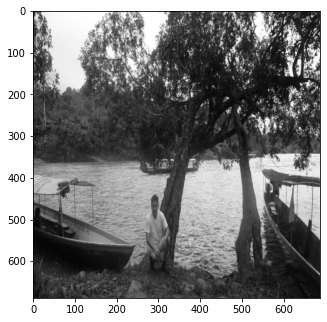

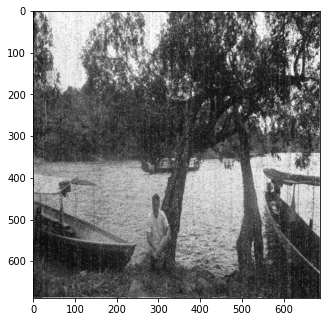

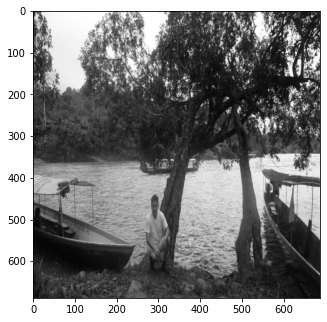

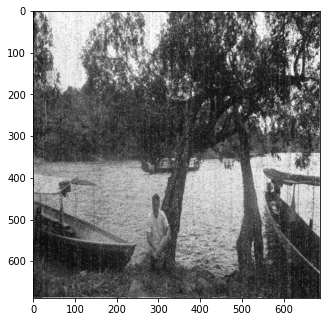

In [3]:
import matplotlib.pyplot as plt
# import the necessary packages
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist

def vizualize_image(img):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.title("Imagen", fontsize=10)
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    return None
    
def show_figure(img):
    n=img.shape[0]
    fig, axs =plt.subplots(1,n)
    plt.gray()
    a = 0
    for k in range(n):
        axs[k].imshow(img[a])
        a = a+1
    plt.show()

# construct the argument parse and parse the arguments

# initialize the number of epochs to train for and batch size
EPOCHS = 400


# Cargar las imagenes respectivas
trainX = data(path_o)
testX =  data(path_o)
# add a channel dimension to every image in the dataset, then scale

# the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0     

## Verificacion de la dimension de las imagenes que se lee
print(trainX.shape)

## Agregar ruido a las iamgenes
trainXNoisy = data(path_n)
testXNoisy = data(path_n)

trainXNoisy = np.expand_dims(trainXNoisy, axis=-1)
testXNoisy = np.expand_dims(testXNoisy, axis=-1)
trainXNoisy = trainXNoisy.astype("float32") / 255.0
testXNoisy = testXNoisy.astype("float32") / 255.0   

## visualizar las imgenes con ruido
show_one(trainX, 0)
show_one(trainXNoisy, 0)
show_one(testX, 0)
show_one(testXNoisy, 0)


In [4]:
## generacion del autoencoder
(encoder, decoder, autoencoder) = ConvAutoencoder.build(trainX.shape[1], trainX.shape[2], 1)
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer='adam')
# train the convolutional autoencoder
H = autoencoder.fit(
	trainXNoisy, trainX,
	validation_data=(testXNoisy, testX),
	epochs=EPOCHS,
    shuffle=True)

Epoch 1/400
1/1 [==============================] - 5s 5s/step - loss: 0.1524 - val_loss: 0.0851
Epoch 2/400
1/1 [==============================] - 1s 1s/step - loss: 0.1599 - val_loss: 0.0847
Epoch 3/400
1/1 [==============================] - 1s 1s/step - loss: 0.0937 - val_loss: 0.0842
Epoch 4/400
1/1 [==============================] - 1s 1s/step - loss: 0.0658 - val_loss: 0.0835
Epoch 5/400
1/1 [==============================] - 1s 1s/step - loss: 0.0465 - val_loss: 0.0829
Epoch 6/400
1/1 [==============================] - 1s 1s/step - loss: 0.0336 - val_loss: 0.0823
Epoch 7/400
1/1 [==============================] - 1s 1s/step - loss: 0.0264 - val_loss: 0.0818
Epoch 8/400
1/1 [==============================] - 1s 1s/step - loss: 0.0228 - val_loss: 0.0814
Epoch 9/400
1/1 [==============================] - 1s 1s/step - loss: 0.0203 - val_loss: 0.0811
Epoch 10/400
1/1 [==============================] - 1s 1s/step - loss: 0.0182 - val_loss: 0.0809
Epoch 11/400
1/1 [=====================

1/1 [==============================] - 1s 1s/step - loss: 1.7639e-04 - val_loss: 0.1244
Epoch 166/400
1/1 [==============================] - 1s 1s/step - loss: 1.7365e-04 - val_loss: 0.1248
Epoch 167/400
1/1 [==============================] - 1s 1s/step - loss: 1.7098e-04 - val_loss: 0.1253
Epoch 168/400
1/1 [==============================] - 1s 1s/step - loss: 1.6838e-04 - val_loss: 0.1257
Epoch 169/400
1/1 [==============================] - 1s 1s/step - loss: 1.6584e-04 - val_loss: 0.1262
Epoch 170/400
1/1 [==============================] - 1s 1s/step - loss: 1.6337e-04 - val_loss: 0.1267
Epoch 171/400
1/1 [==============================] - 1s 1s/step - loss: 1.6095e-04 - val_loss: 0.1271
Epoch 172/400
1/1 [==============================] - 1s 1s/step - loss: 1.5859e-04 - val_loss: 0.1276
Epoch 173/400
1/1 [==============================] - 1s 1s/step - loss: 1.5628e-04 - val_loss: 0.1280
Epoch 174/400
1/1 [==============================] - 1s 1s/step - loss: 1.5402e-04 - val_loss: 0

1/1 [==============================] - 1s 1s/step - loss: 2.0601e-05 - val_loss: 0.1162
Epoch 326/400
1/1 [==============================] - 1s 1s/step - loss: 2.0463e-05 - val_loss: 0.1172
Epoch 327/400
1/1 [==============================] - 1s 1s/step - loss: 2.0339e-05 - val_loss: 0.1149
Epoch 328/400
1/1 [==============================] - 1s 1s/step - loss: 2.0326e-05 - val_loss: 0.1164
Epoch 329/400
1/1 [==============================] - 1s 1s/step - loss: 2.0363e-05 - val_loss: 0.1133
Epoch 330/400
1/1 [==============================] - 1s 1s/step - loss: 2.0686e-05 - val_loss: 0.1158
Epoch 331/400
1/1 [==============================] - 1s 1s/step - loss: 2.1116e-05 - val_loss: 0.1113
Epoch 332/400
1/1 [==============================] - 1s 1s/step - loss: 2.2332e-05 - val_loss: 0.1154
Epoch 333/400
1/1 [==============================] - 1s 1s/step - loss: 2.3535e-05 - val_loss: 0.1087
Epoch 334/400
1/1 [==============================] - 1s 1s/step - loss: 2.6632e-05 - val_loss: 0

In [5]:
decoded = autoencoder.predict(testXNoisy)

In [6]:
decoded.shape

(1, 688, 688, 1)

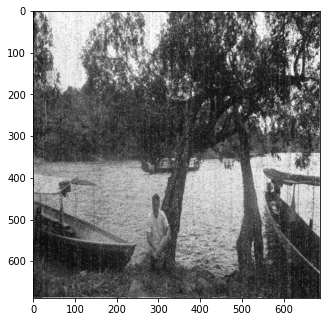

In [7]:
show_one(testXNoisy,0)

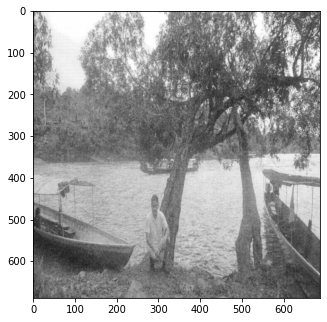

In [8]:
show_one(decoded,0)

In [9]:
## convertir de tensor a una numpy
norm_image = cv2.normalize(decoded, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

## convertir al tipo de dato inicial
norm_image = norm_image.astype(np.uint8)

In [10]:
cv2.imwrite(os.path.join(path_r , 'reutarada.jpg'), norm_image[0,:,:,0])

True

In [74]:
## Funcion para calcular el error cuadratico medio de dos imagenes
def mse(a, b):
    a = a.reshape(a.shape[1],a.shape[2])
    b = b.reshape(b.shape[1],b.shape[2])
    err = np.sum((a-b)**2)
    err = err/(a.shape[0]*a.shape[1])
    return err

def psnr(a, b):
    a = a.reshape(a.shape[1],a.shape[2])
    b = b.reshape(b.shape[1],b.shape[2])
    err = np.sum((a-b)**2)
    err = err/(a.shape[0]*a.shape[1])
    if err ==0:
        return 1
    else:
        max =1
        valor = 20*np.log10(max/np.sqrt(err))
        return valor
    
def resize(a):
    a = a.reshape(a.shape[1],a.shape[2])
    return a

In [72]:
error = mse(testX, decoded)
print(error)

0.06478972200318373


In [56]:
error1 = psnr(testX, decoded)
print(error1)

11.88493883501846


In [76]:
A=resize(testXNoisy)
B=resize(decoded)

In [77]:
(score, diff) = compare_ssim(A, B, full=True)

In [78]:
print("El valor del la calificacion es ",score," y la diferencia entre estos es ",diff)

El valor del la calificacion es  0.31026120750364733  y la diferencia entre estos es  [[ 0.00899898 -0.06347503 -0.12313905 ... -0.16370579 -0.12434261
  -0.17525213]
 [-0.07767023 -0.12437914 -0.1469512  ...  0.03510325  0.07740619
   0.05914058]
 [-0.08603444 -0.12334881 -0.10937362 ...  0.07830842  0.1011603
   0.09573433]
 ...
 [-0.06377124  0.01018459  0.01510448 ... -0.16140109 -0.15256437
  -0.17080555]
 [-0.06877276  0.01069713  0.01546061 ... -0.15947051 -0.15978713
  -0.18294356]
 [-0.08626944 -0.01088979 -0.00784446 ... -0.18140234 -0.17772205
  -0.19795266]]


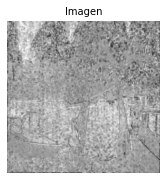

In [79]:
vizualize_image(diff)
